[View in Colaboratory](https://colab.research.google.com/github/adowaconan/Deep_learning_fMRI/blob/master/4_3_Autoencoder_in_fMRI_continue_convolutional_neural_network_with_transfer_learning.ipynb)

This script is to illustrate how to use convolutional neural network to decode fMRI data, and we present a model comparison between some baseline models and the convolutional neural network at the between-subject level.

In [2]:
!pip install -U -q PyDrive
!pip install tqdm
!apt-get install swig
!pip install -U pymvpa2
!pip install -U seaborn

# this lets you access to googel drive shared files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# why not numpy?
import numpy as np
import zipfile
from sklearn.metrics import roc_auc_score


from glob import glob # useless
from tqdm import tqdm # maybe useful
import pickle # very useful
from collections import Counter # I'm a counter
from mvpa2.mappers.fx import mean_group_sample # pymvpa
from mvpa2.generators.partition import NFoldPartitioner # pymvpa
from mvpa2.base.node import ChainNode # pymvpa
from mvpa2.generators.resampling import Balancer # pymvpa
from mvpa2.generators.base import Sifter # pymvpa
from mvpa2.mappers.base import Mapper # pymvpa
from keras.layers import Dense,Dropout,BatchNormalization
from keras.layers import Input, AveragePooling3D,Reshape
from keras.layers import Conv2D,Conv2DTranspose
from keras.layers import GaussianNoise # add noise to our data
from keras.layers import Flatten,Dense,LeakyReLU,Conv3DTranspose
from keras.models import Model
import keras
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers
from sklearn import metrics
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

data_id = 'https://drive.google.com/open?id=1sMQh_8qhCwN7N1yM8mTEBT9m8q7l_0iv'.split('id=')[-1]
zip_import = drive.CreateFile({'id':data_id})
zip_import.GetContentFile('{}'.format('all_bin.pkl'))

    100% |████████████████████████████████| 51kB 3.5MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 0 not upgraded.
Need to get 1,080 kB of archives.
After this operation, 5,657 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig3.0 amd64 3.0.10-1.2 [1,074 kB]
Get:2 http://archive.ubuntu.com/ubuntu artful/universe amd64 swig amd64 3.0.10-1.2 [6,384 B]
Fetched 1,080 kB in 1s (770 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.10-1.2_amd64.deb ...
Unpacking swig3.0 (3.0.10-1.2) ...
Selecting previously unselected package swig

Using TensorFlow backend.


# Read condition

## Experiment:

### Subjects in the sanner, and were instructed to read the word repeatedly as it was present. The words can be divided into 2 semantic categories: living animals and non-living tools

## words:

'llave', 'lapiz', 'tijera', 'aguja', 'pinza', 'sierra', 'clavo',
'pincel', 'alicate', 'tuerca', 'navaja', 'cepillo', 'taladro',
'soplete', 'tornillo', 'cuchara', 'martillo', 'cuchillo', 'tigre',
'gallo', 'perro', 'oveja', 'cerdo', 'gorila', 'burro', 'yegua',
'ardilla', 'conejo', 'gallina', 'caballo', 'ballena', 'pantera',
'camello', 'tortuga', 'elefante', 'canguro'
<br />**can you divide them?**

In [0]:
dataset_ = pickle.load(open('all_bin.pkl','rb'))
dataset = dataset_[dataset_.sa.context == 'read']

In [3]:
print(dataset.summary())

Dataset: 1544x16130@float32, <sa: categories,chunks,context,id,targets,time_coords,time_indices,trials,words>, <fa: voxel_indices>, <a: imgaffine,imghdr,imgtype,mapper,voxel_dim,voxel_eldim>
stats: mean=8.95748e-10 std=0.993167 var=0.98638 min=-6.82599 max=6.5985

Counts of targets in each chunk:
  chunks\targets animal tool
                   ---   ---
        0          111   111
        2          110   111
        4          110   110
        6          108   115
        8          109   109
       10          108   110
       12          111   111

Summary for targets across chunks
  targets mean  std min max #chunks
  animal   110 1.18 108 111    7
   tool    111 1.77 109 115    7

Summary for chunks across targets
  chunks mean std min max #targets
    0     111  0  111 111     2
    2     110 0.5 110 111     2
    4     110  0  110 110     2
    6     112 3.5 108 115     2
    8     109  0  109 109     2
   10     109  1  108 110     2
   12     111  0  111 111     2
Sequence s

In [0]:
from glob import glob
from tqdm import tqdm
import pickle
from collections import Counter
from mvpa2.mappers.fx import mean_group_sample
from mvpa2.generators.partition import NFoldPartitioner
from mvpa2.base.node import ChainNode
from mvpa2.generators.resampling import Balancer
from mvpa2.generators.base import Sifter
from mvpa2.mappers.base import Mapper
from keras.layers import Conv3D,Dense,Dropout,BatchNormalization
from keras.layers import Input, AveragePooling3D,Reshape
from keras.layers import Conv2D,Conv2DTranspose
from keras.layers import GaussianNoise
from keras.layers import Flatten,Dense,LeakyReLU,Conv3DTranspose
from keras.models import Model
import keras
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras import regularizers
from sklearn import metrics
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import MinMaxScaler

In [0]:
from keras.applications import VGG19
model_vgg19 = VGG19(include_top=False, # do not include the classifier
                    weights='imagenet', # get the pretrained weights
                    input_tensor=None, # don't know what this is
                    input_shape=(97,97,3), # decide the input shape
                    pooling='avg', # use global average for the pooling
                    classes=1000)# doesen't matter

In [0]:
def CNN_transfer_learning_model(shape,pretrain = 'vgg'):
    x,y,z = shape
    inputs = Input(shape = (x,y,z),
                   batch_shape = (None, x,y,z),
                   dtype = 'float32',
                   name = 'inputs')
    GaussianNoise(stddev = 0.1,)(inputs)
#    layer1 = Conv2DTranspose(filters = 3,
#                             kernel_size = 10,
#                             padding = 'valid',
#                             activation = 'linear',
#                             name = 'layer1',
#                             )(inputs)
    layer1 = Conv2D(filters = 3,
                    kernel_size = 1,
                    activation = 'relu',
                    name = 'layer1',
                    )(inputs)
    
#    layer1.set_shape((None,97,97,3))
    if pretrain == 'vgg':
        model_vgg19 = VGG19(include_top=False, # do not include the classifier
                        weights='imagenet', # get the pretrained weights
                        input_tensor=None, # don't know what this is
                        input_shape=(88,88,3), # decide the input shape
                        pooling='avg', # use global average for the pooling
                        classes=1000)# doesen't matter
        for layer in model_vgg19.layers:
            layer.trainable = False
        pretrained_model    = model_vgg19(layer1)
    elif pretrain == 'resnet': # input shape be at least 197 x 197
        model_resnet = ResNet50(include_top=False, # do not include the classifier
                                weights='imagenet', # get the pretrained weights
                                input_tensor=None, # don't know what this is
                                input_shape=(97,97,3), # decide the input shape
                                pooling='avg', # use global average for the pooling
                                classes=1000)# doesen't matter
        for layer in model_resnet.layers:
            layer.trainable = False
        pretrained_model    = model_resnet(layer1)
    elif pretrain == 'nasnet':
        model_nasnet = nasnet.NASNetMobile(include_top=False, # do not include the classifier
                                weights='imagenet', # get the pretrained weights
                                input_tensor=None, # don't know what this is
                                input_shape=(88,88,3), # decide the input shape
                                pooling='avg', # use global average for the pooling
                                classes=1000)# doesen't matter
        for layer in model_nasnet.layers:
            layer.trainable = False
        pretrained_model    = model_nasnet(layer1)
    
    layer2 = Dense(256,activation='relu',name='dense1')(pretrained_model)
    layer2 = BatchNormalization(name='norm1')(layer2)
    layer2 = Dropout(0.5,name='drop1')(layer2)
    layer3 = Dense(128,activation='relu',name='dense2')(layer2)
    layer3 = BatchNormalization(name='norm2')(layer3)
    layer3 = Dropout(0.5,name='drop2')(layer3)
    outputs = Dense(2,activation='softmax',name='outputs')(layer3)
    model = Model(inputs,outputs,name='clf')
    return model

In [7]:
model = CNN_transfer_learning_model((88, 88, 66))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 88, 88, 66)        0         
_________________________________________________________________
layer1 (Conv2D)              (None, 88, 88, 3)         201       
_________________________________________________________________
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
dense1 (Dense)               (None, 256)               131328    
_________________________________________________________________
norm1 (BatchNormalization)   (None, 256)               1024      
_________________________________________________________________
drop1 (Dropout)              (None, 256)               0         
_________________________________________________________________
dense2 (Dense)               (None, 128)               32896     
__________

In [8]:
165433./20190585

0.008193571409644643

In [0]:
pr_ds = dataset.get_mapped(mean_group_sample(['chunks','trials'],order='occurrence'))
pr_ds.samples = MinMaxScaler().fit_transform(pr_ds.samples)
data = pr_ds.a.mapper.reverse(pr_ds.samples)
labels = pr_ds.sa.targets
chunks = pr_ds.sa.chunks
label_map = {'animal':[0,1],
             'tool':[1,0]}
labels = np.array([label_map[item] for item in labels])

In [0]:
model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy,metrics=['acc'])
model.fit(data,labels,validation_split=.2,epochs=10,batch_size=16)

Train on 201 samples, validate on 51 samples
Epoch 1/10
201/201 [==============================] - 64s 319ms/step - loss: 1.1167 - acc: 0.5572 - val_loss: 0.8739 - val_acc: 0.5294
Epoch 2/10
201/201 [==============================] - 62s 311ms/step - loss: 0.9529 - acc: 0.5672 - val_loss: 1.6737 - val_acc: 0.5098
Epoch 3/10
201/201 [==============================] - 63s 314ms/step - loss: 1.0270 - acc: 0.5423 - val_loss: 1.7867 - val_acc: 0.4902
Epoch 4/10
 48/201 [======>.......................] - ETA: 43s - loss: 0.8525 - acc: 0.5208

In [0]:
from IPython.display import Image
image_id = 'https://drive.google.com/open?id=1qTtCrO-qvdPirYCr6nRKpQp5MnOnAS-i'.split('id=')[-1]
image = drive.CreateFile({'id':image_id})
image.GetContentFile('{}'.format('CNN.png'))

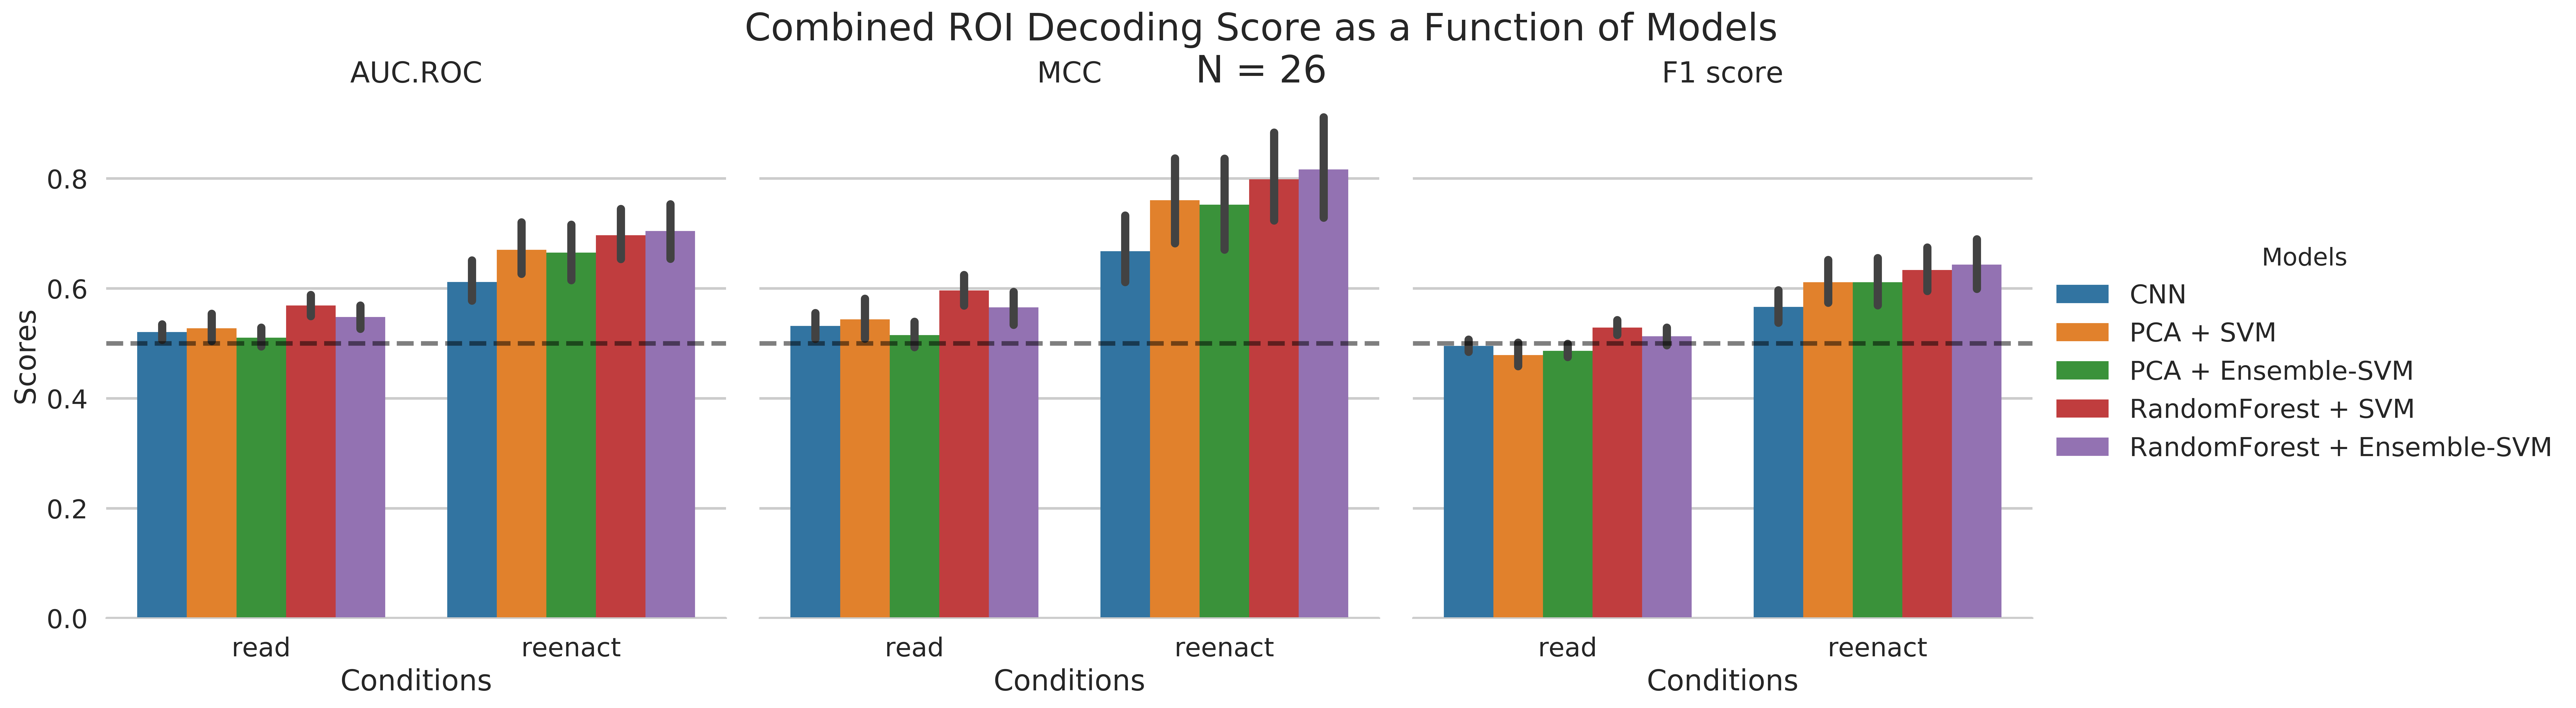

In [5]:
Image('CNN.png',height=400)